## Import libraries

In [30]:
import numpy as np
import scipy.io
import scipy.linalg
import sklearn.metrics
#import bob.math
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn import svm
from sklearn import linear_model
import scipy.io as sio
import scipy.sparse as sp
from scipy.sparse.linalg import svds as SVD

## Define a kernel function

In [34]:
def kernel(ker, X1, X2, gamma):
    K = None
    if not ker or ker == 'primal':
        K = X1
    elif ker == 'linear':
        if X2 is not None:
            K = sklearn.metrics.pairwise.linear_kernel(np.asarray(X1).T, np.asarray(X2).T)
        else:
            K = sklearn.metrics.pairwise.linear_kernel(np.asarray(X1).T)
    elif ker == 'rbf':
        if X2 is not None:
            K = sklearn.metrics.pairwise.rbf_kernel(np.asarray(X1).T, np.asarray(X2).T, gamma)
        else:
            K = sklearn.metrics.pairwise.rbf_kernel(np.asarray(X1).T, None, gamma)
    return K

# Implement TCA

In [40]:
class TCA:
    def __init__(self, kernel_type='primal', dim=30, lamb=1, gamma=1):
        '''
        Init func
        :param kernel_type: kernel, values: 'primal' | 'linear' | 'rbf'
        :param dim: dimension after transfer
        :param lamb: lambda value in equation
        :param gamma: kernel bandwidth for rbf kernel
        '''
        self.kernel_type = kernel_type
        self.dim = dim
        self.lamb = lamb
        self.gamma = gamma

    def fit(self, Xs, Xt):
        '''
        Transform Xs and Xt
        :param Xs: ns * n_feature, source feature
        :param Xt: nt * n_feature, target feature
        :return: Xs_new and Xt_new after TCA
        '''
        X = np.hstack((Xs.T, Xt.T))
        X /= np.linalg.norm(X, axis=0)
        m, n = X.shape
        ns, nt = len(Xs), len(Xt)
        e = np.vstack((1 / ns * np.ones((ns, 1)), -1 / nt * np.ones((nt, 1))))
        M = e * e.T
        M = M / np.linalg.norm(M, 'fro')
        H = np.eye(n) - 1 / n * np.ones((n, n))
        K = kernel(self.kernel_type, X, None, gamma=self.gamma)
        n_eye = m if self.kernel_type == 'primal' else n
        a, b = np.linalg.multi_dot([K, M, K.T]) + self.lamb * np.eye(n_eye), np.linalg.multi_dot([K, H, K.T])
        w, V = scipy.linalg.eig(a, b)
        ind = np.argsort(w)
        A = V[:, ind[:self.dim]]
        Z = np.dot(A.T, K)
        Z /= np.linalg.norm(Z, axis=0)
        Xs_new, Xt_new = Z[:, :ns].T, Z[:, ns:].T
        return Xs_new, Xt_new

    def fit_predict(self, Xs, Ys, Xt, Yt):
        '''
        Transform Xs and Xt, then make predictions on target using 1NN
        :param Xs: ns * n_feature, source feature
        :param Ys: ns * 1, source label
        :param Xt: nt * n_feature, target feature
        :param Yt: nt * 1, target label
        :return: Accuracy and predicted_labels on the target domain
        '''
        Xs_new, Xt_new = self.fit(Xs, Xt)
        clf = KNeighborsRegressor(n_neighbors=1)
        clf.fit(Xs_new, Ys.ravel())
        y_pred = clf.predict(Xt_new)
        acc = sklearn.metrics.mean_squared_error(Yt, y_pred)
        return acc, y_pred

## Implement BDA

In [5]:
class BDA:
    def __init__(self, kernel_type='primal', dim=30, lamb=1, mu=0.5, gamma=1, T=10, mode='BDA', estimate_mu=False):
        '''
        Init func
        :param kernel_type: kernel, values: 'primal' | 'linear' | 'rbf'
        :param dim: dimension after transfer
        :param lamb: lambda value in equation
        :param mu: mu. Default is -1, if not specificied, it calculates using A-distance
        :param gamma: kernel bandwidth for rbf kernel
        :param T: iteration number
        :param mode: 'BDA' | 'WBDA'
        :param estimate_mu: True | False, if you want to automatically estimate mu instead of manally set it
        '''
        self.kernel_type = kernel_type
        self.dim = dim
        self.lamb = lamb
        self.mu = mu
        self.gamma = gamma
        self.T = T
        self.mode = mode
        self.estimate_mu = estimate_mu

    def fit_predict(self, Xs, Ys, Xt, Yt):
        '''
        Transform and Predict using 1NN as JDA paper did
        :param Xs: ns * n_feature, source feature
        :param Ys: ns * 1, source label
        :param Xt: nt * n_feature, target feature
        :param Yt: nt * 1, target label
        :return: acc, y_pred, list_acc
        '''
        list_acc = []
        X = np.hstack((Xs.T, Xt.T))
        X /= np.linalg.norm(X, axis=0)
        m, n = X.shape
        ns, nt = len(Xs), len(Xt)
        e = np.vstack((1 / ns * np.ones((ns, 1)), -1 / nt * np.ones((nt, 1))))
        C = len(np.unique(Ys))
        H = np.eye(n) - 1 / n * np.ones((n, n))
        mu = self.mu
        M = 0
        Y_tar_pseudo = None
        Xs_new = None
        for t in range(self.T):
            N = 0
            M0 = e * e.T * C
            if Y_tar_pseudo is not None and len(Y_tar_pseudo) == nt:
                '''for c in range(1, C + 1):
                    e = np.zeros((n, 1))
                    Ns = len(Ys[np.where(Ys == c)])
                    Nt = len(Y_tar_pseudo[np.where(Y_tar_pseudo == c)])

                    if self.mode == 'WBDA':
                        Ps = Ns / len(Ys)
                        Pt = Nt / len(Y_tar_pseudo)
                        alpha = Pt / Ps
                        mu = 1
                    else:
                        alpha = 1

                    tt = Ys == c
                    e[np.where(tt == True)] = 1 / Ns
                    yy = Y_tar_pseudo == c
                    ind = np.where(yy == True)
                    inds = [item + ns for item in ind]
                    e[tuple(inds)] = -alpha / Nt
                    e[np.isinf(e)] = 0
                    N = N + np.dot(e, e.T)'''

            # In BDA, mu can be set or automatically estimated using A-distance
            # In WBDA, we find that setting mu=1 is enough
            if self.estimate_mu and self.mode == 'BDA':
                if Xs_new is not None:
                    mu = estimate_mu(Xs_new, Ys, Xt_new, Y_tar_pseudo)
                else:
                    mu = 0
            M = (1 - mu) * M0 + mu * N
            M /= np.linalg.norm(M, 'fro')
            K = kernel(self.kernel_type, X, None, gamma=self.gamma)
            n_eye = m if self.kernel_type == 'primal' else n
            a, b = np.linalg.multi_dot(
                [K, M, K.T]) + self.lamb * np.eye(n_eye), np.linalg.multi_dot([K, H, K.T])
            w, V = scipy.linalg.eig(a, b)
            ind = np.argsort(w)
            A = V[:, ind[:self.dim]]
            Z = np.dot(A.T, K)
            Z /= np.linalg.norm(Z, axis=0)
            Xs_new, Xt_new = Z[:, :ns].T, Z[:, ns:].T

            clf = sklearn.neighbors.KNeighborsRegressor(n_neighbors=1)
            clf.fit(Xs_new, Ys.ravel())
            Y_tar_pseudo = clf.predict(Xt_new)
            acc = sklearn.metrics.mean_squared_error(Yt, Y_tar_pseudo)
            list_acc.append(acc)
            print('{} iteration [{}/{}]: Acc: {:.4f}'.format(self.mode, t + 1, self.T, acc))
        return acc, Y_tar_pseudo, list_acc


## Implement JDA

In [6]:
class JDA:
    def __init__(self, kernel_type='primal', dim=30, lamb=1, gamma=1, T=10):
        '''
        Init func
        :param kernel_type: kernel, values: 'primal' | 'linear' | 'rbf'
        :param dim: dimension after transfer
        :param lamb: lambda value in equation
        :param gamma: kernel bandwidth for rbf kernel
        :param T: iteration number
        '''
        self.kernel_type = kernel_type
        self.dim = dim
        self.lamb = lamb
        self.gamma = gamma
        self.T = T

    def fit_predict(self, Xs, Ys, Xt, Yt):
        '''
        Transform and Predict using 1NN as JDA paper did
        :param Xs: ns * n_feature, source feature
        :param Ys: ns * 1, source label
        :param Xt: nt * n_feature, target feature
        :param Yt: nt * 1, target label
        :return: acc, y_pred, list_acc
        '''
        list_acc = []
        X = np.hstack((Xs.T, Xt.T))
        X /= np.linalg.norm(X, axis=0)
        m, n = X.shape
        ns, nt = len(Xs), len(Xt)
        e = np.vstack((1 / ns * np.ones((ns, 1)), -1 / nt * np.ones((nt, 1))))
        C = len(np.unique(Ys))
        H = np.eye(n) - 1 / n * np.ones((n, n))

        M = 0
        Y_tar_pseudo = None
        for t in range(self.T):
            N = 0
            M0 = e * e.T * C
            if Y_tar_pseudo is not None and len(Y_tar_pseudo) == nt:
                '''for c in range(1, C + 1):
                    e = np.zeros((n, 1))
                    tt = Ys == c
                    e[np.where(tt == True)] = 1 / len(Ys[np.where(Ys == c)])
                    yy = Y_tar_pseudo == c
                    ind = np.where(yy == True)
                    inds = [item + ns for item in ind]
                    e[tuple(inds)] = -1 / len(Y_tar_pseudo[np.where(Y_tar_pseudo == c)])
                    e[np.isinf(e)] = 0
                    N = N + np.dot(e, e.T)'''
            M = M0 + N
            M = M / np.linalg.norm(M, 'fro')
            K = kernel(self.kernel_type, X, None, gamma=self.gamma)
            n_eye = m if self.kernel_type == 'primal' else n
            a, b = np.linalg.multi_dot([K, M, K.T]) + self.lamb * np.eye(n_eye), np.linalg.multi_dot([K, H, K.T])
            w, V = scipy.linalg.eig(a, b)
            ind = np.argsort(w)
            A = V[:, ind[:self.dim]]
            Z = np.dot(A.T, K)
            Z /= np.linalg.norm(Z, axis=0)
            Xs_new, Xt_new = Z[:, :ns].T, Z[:, ns:].T

            clf = sklearn.neighbors.KNeighborsRegressor(n_neighbors=7)
            clf.fit(Xs_new, Ys.ravel())
            Y_tar_pseudo = clf.predict(Xt_new)
            acc = sklearn.metrics.mean_squared_error(Yt, Y_tar_pseudo)
            list_acc.append(acc)
            print('JDA iteration [{}/{}]: MSE: {:.4f}'.format(t + 1, self.T, acc))
        return acc, Y_tar_pseudo, list_acc

## Implement Coral

In [7]:
class CORAL:
    def __init__(self):
        super(CORAL, self).__init__()

    def fit(self, Xs, Xt):
        '''
        Perform CORAL on the source domain features
        :param Xs: ns * n_feature, source feature
        :param Xt: nt * n_feature, target feature
        :return: New source domain features
        '''
        cov_src = np.cov(Xs.T) + np.eye(Xs.shape[1])
        cov_tar = np.cov(Xt.T) + np.eye(Xt.shape[1])
        A_coral = np.dot(scipy.linalg.fractional_matrix_power(cov_src, -0.5),
                         scipy.linalg.fractional_matrix_power(cov_tar, 0.5))
        np.linalg.multi_dot([Xs, scipy.linalg.fractional_matrix_power(cov_src, -0.5), scipy.linalg.fractional_matrix_power(cov_tar, 0.5)])
        Xs_new = np.real(np.dot(Xs, A_coral))
        return Xs_new

    def fit_predict(self, Xs, Ys, Xt, Yt, k):
        '''
        Perform CORAL, then predict using 1NN classifier
        :param Xs: ns * n_feature, source feature
        :param Ys: ns * 1, source label
        :param Xt: nt * n_feature, target feature
        :param Yt: nt * 1, target label
        :return: Accuracy and predicted labels of target domain
        '''
        Xs_new = self.fit(Xs, Xt)
        clf = sklearn.neighbors.KNeighborsRegressor(n_neighbors=k)
        clf.fit(Xs_new, Ys.ravel())
        y_pred = clf.predict(Xt)
        acc = sklearn.metrics.mean_squared_error(Yt, y_pred)
        return acc, y_pred

## Implement GFK

In [8]:
class GFK:
    def __init__(self, dim=20):
        '''
        Init func
        :param dim: dimension after GFK
        '''
        self.dim = dim
        self.eps = 1e-20

    def fit(self, Xs, Xt, norm_inputs=None):
        '''
        Obtain the kernel G
        :param Xs: ns * n_feature, source feature
        :param Xt: nt * n_feature, target feature
        :param norm_inputs: normalize the inputs or not
        :return: GFK kernel G
        '''
        if norm_inputs:
            source, mu_source, std_source = self.znorm(Xs)
            target, mu_target, std_target = self.znorm(Xt)
        else:
            mu_source = np.zeros(shape=(Xs.shape[1]))
            std_source = np.ones(shape=(Xs.shape[1]))
            mu_target = np.zeros(shape=(Xt.shape[1]))
            std_target = np.ones(shape=(Xt.shape[1]))
            source = Xs
            target = Xt

        Ps = self.train_pca(source, mu_source, std_source, 0.99)
        Pt = self.train_pca(target, mu_target, std_target, 0.99)
        Ps = np.hstack((Ps.weights, scipy.linalg.null_space(Ps.weights.T)))
        Pt = Pt.weights[:, :self.dim]
        N = Ps.shape[1]
        dim = Pt.shape[1]

        # Principal angles between subspaces
        QPt = np.dot(Ps.T, Pt)

        # [V1,V2,V,Gam,Sig] = gsvd(QPt(1:dim,:), QPt(dim+1:end,:));
        A = QPt[0:dim, :].copy()
        B = QPt[dim:, :].copy()

        # Equation (2)
        [V1, V2, V, Gam, Sig] = bob.math.gsvd(A, B)
        V2 = -V2

        # Some sanity checks with the GSVD
        I = np.eye(V1.shape[1])
        I_check = np.dot(Gam.T, Gam) + np.dot(Sig.T, Sig)
        assert np.sum(abs(I - I_check)) < 1e-10

        theta = np.arccos(np.diagonal(Gam))

        # Equation (6)
        B1 = np.diag(0.5 * (1 + (np.sin(2 * theta) / (2. * np.maximum
        (theta, 1e-20)))))
        B2 = np.diag(0.5 * ((np.cos(2 * theta) - 1) / (2 * np.maximum(
            theta, self.eps))))
        B3 = B2
        B4 = np.diag(0.5 * (1 - (np.sin(2 * theta) / (2. * np.maximum
        (theta, self.eps)))))

        # Equation (9) of the suplementary matetial
        delta1_1 = np.hstack((V1, np.zeros(shape=(dim, N - dim))))
        delta1_2 = np.hstack((np.zeros(shape=(N - dim, dim)), V2))
        delta1 = np.vstack((delta1_1, delta1_2))

        delta2_1 = np.hstack((B1, B2, np.zeros(shape=(dim, N - 2 * dim))))
        delta2_2 = np.hstack((B3, B4, np.zeros(shape=(dim, N - 2 * dim))))
        delta2_3 = np.zeros(shape=(N - 2 * dim, N))
        delta2 = np.vstack((delta2_1, delta2_2, delta2_3))

        delta3_1 = np.hstack((V1, np.zeros(shape=(dim, N - dim))))
        delta3_2 = np.hstack((np.zeros(shape=(N - dim, dim)), V2))
        delta3 = np.vstack((delta3_1, delta3_2)).T

        delta = np.linalg.multi_dot([delta1, delta2, delta3])
        G = np.linalg.multi_dot([Ps, delta, Ps.T])
        sqG = scipy.real(scipy.linalg.fractional_matrix_power(G, 0.5))
        Xs_new, Xt_new = np.dot(sqG, Xs.T).T, np.dot(sqG, Xt.T).T
        return G, Xs_new, Xt_new

    def fit_predict(self, Xs, Ys, Xt, Yt):
        '''
        Fit and use 1NN to classify
        :param Xs: ns * n_feature, source feature
        :param Ys: ns * 1, source label
        :param Xt: nt * n_feature, target feature
        :param Yt: nt * 1, target label
        :return: Accuracy, predicted labels of target domain, and G
        '''
        G, Xs_new, Xt_new = self.fit(Xs, Xt)
        clf = KNeighborsClassifier(n_neighbors=1)
        clf.fit(Xs_new, Ys.ravel())
        y_pred = clf.predict(Xt_new)
        acc = np.mean(y_pred == Yt.ravel())
        return acc, y_pred, G

    def principal_angles(self, Ps, Pt):
        """
        Compute the principal angles between source (:math:`P_s`) and target (:math:`P_t`) subspaces in a Grassman which is defined as the following:

        :math:`d^{2}(P_s, P_t) = \sum_{i}( \theta_i^{2} )`,

        """
        # S = cos(theta_1, theta_2, ..., theta_n)
        _, S, _ = np.linalg.svd(np.dot(Ps.T, Pt))
        thetas_squared = np.arccos(S) ** 2

        return np.sum(thetas_squared)

    def train_pca(self, data, mu_data, std_data, subspace_dim):
        '''
        Modified PCA function, different from the one in sklearn
        :param data: data matrix
        :param mu_data: mu
        :param std_data: std
        :param subspace_dim: dim
        :return: a wrapped machine object
        '''
        t = bob.learn.linear.PCATrainer()
        machine, variances = t.train(data)

        # For re-shaping, we need to copy...
        variances = variances.copy()

        # compute variance percentage, if desired
        if isinstance(subspace_dim, float):
            cummulated = np.cumsum(variances) / np.sum(variances)
            for index in range(len(cummulated)):
                if cummulated[index] > subspace_dim:
                    subspace_dim = index
                    break
            subspace_dim = index
        machine.resize(machine.shape[0], subspace_dim)
        machine.input_subtract = mu_data
        machine.input_divide = std_data

        return machine

    def znorm(self, data):
        """
        Z-Normaliza
        """
        mu = np.average(data, axis=0)
        std = np.std(data, axis=0)
        data = (data - mu) / std
        return data, mu, std

    def subspace_disagreement_measure(self, Ps, Pt, Pst):
        """
        Get the best value for the number of subspaces
        For more details, read section 3.4 of the paper.
        **Parameters**
          Ps: Source subspace
          Pt: Target subspace
          Pst: Source + Target subspace
        """

        def compute_angles(A, B):
            _, S, _ = np.linalg.svd(np.dot(A.T, B))
            S[np.where(np.isclose(S, 1, atol=self.eps) == True)[0]] = 1
            return np.arccos(S)

        max_d = min(Ps.shape[1], Pt.shape[1], Pst.shape[1])
        alpha_d = compute_angles(Ps, Pst)
        beta_d = compute_angles(Pt, Pst)
        d = 0.5 * (np.sin(alpha_d) + np.sin(beta_d))
        return np.argmax(d)

## Implement KMM

In [9]:
class KMM:
    def __init__(self, kernel_type='linear', gamma=1.0, B=1.0, eps=None):
        '''
        Initialization function
        :param kernel_type: 'linear' | 'rbf'
        :param gamma: kernel bandwidth for rbf kernel
        :param B: bound for beta
        :param eps: bound for sigma_beta
        '''
        self.kernel_type = kernel_type
        self.gamma = gamma
        self.B = B
        self.eps = eps

    def fit(self, Xs, Xt):
        '''
        Fit source and target using KMM (compute the coefficients)
        :param Xs: ns * dim
        :param Xt: nt * dim
        :return: Coefficients (Pt / Ps) value vector (Beta in the paper)
        '''
        ns = Xs.shape[0]
        nt = Xt.shape[0]
        if self.eps == None:
            self.eps = self.B / np.sqrt(ns)
        K = kernel(self.kernel_type, Xs, None, self.gamma)
        kappa = np.sum(kernel(self.kernel_type, Xs, Xt, self.gamma) * float(ns) / float(nt), axis=1)

        K = matrix(K.astype(np.double))
        kappa = matrix(kappa.astype(np.double))
        G = matrix(np.r_[np.ones((1, ns)), -np.ones((1, ns)), np.eye(ns), -np.eye(ns)])
        h = matrix(np.r_[ns * (1 + self.eps), ns * (self.eps - 1), self.B * np.ones((ns,)), np.zeros((ns,))])

        sol = solvers.qp(K, -kappa, G, h)
        beta = np.array(sol['x'])
        return beta


## Implement SCL

In [10]:
class SCL(object):
    '''
    class of structural correspondence learning 
    '''
    def __init__(self, l2=1.0, num_pivots=10, base_classifer=LinearSVR()):
        self.l2 = l2
        self.num_pivots = num_pivots
        self.W = 0
        self.base_classifer = base_classifer
        # self.train_data_dim = None

    def fit(self, Xs, Xt):
        '''
        find pivot features and transfer the Xs and Xt
        Param Xs: source data
        Param Xt: target data
        output Xs_new: new source data features
        output Xt_new: new target data features
        output W: transform matrix
        '''
        _, ds = Xs.shape
        _, dt = Xt.shape
        assert ds == dt
        X = np.concatenate((Xs, Xt), axis=0)
        ix = np.argsort(np.sum(X, axis=0))
        ix = ix[::-1][:self.num_pivots]
        pivots = (X[:, ix]>0).astype('float')
        p = np.zeros((ds, self.num_pivots))
        # train for the classifers 
        for i in range(self.num_pivots):
            clf = linear_model.SGDRegressor(loss="squared_error", alpha=self.l2)
            clf.fit(X, pivots[:, i])
            p[:, i] = clf.coef_
        _, W = np.linalg.eig(np.cov(p))
        W = W[:, :self.num_pivots].astype('float')
        self.W = W
        Xs_new = np.concatenate((np.dot(Xs, W), Xs), axis=1)
        Xt_new = np.concatenate((np.dot(Xt, W), Xt), axis=1)

        return Xs_new, Xt_new, W

    def transform(self, X):
        '''
        transform the origianl data by add new features
        Param X: original data
        output x_new: X with new features
        '''
        X_new = np.concatenate((np.dot(X, self.W),X), axis=1)
        return X_new
    
    def fit_predict(self, Xs, Xt, X_test, Ys, Y_test):
        self.fit(Xs, Xt)
        Xs = self.transform(Xs)
        self.base_classifer.fit(Xs, Ys)
        X_test = self.transform(X_test)
        y_pred = self.base_classifer.predict(X_test)
        acc = mean_squared_error(Y_test, y_pred)
        return acc

## SFA

In [12]:
class SFA:
    '''
    spectrual feature alignment
    '''

    def __init__(self, l=500, K=100, base_classifer=svm.SVR()):
        self.l = l
        self.K = K
        self.m = 0
        self.ut = None
        self.phi = 1
        self.base_classifer = base_classifer
        self.ix = None
        self._ix = None
        return

    def fit(self, Xs, Xt):

        ix_s = np.argsort(np.sum(Xs, axis=0))
        ix_t = np.argsort(np.sum(Xt, axis=0))

        ix_s = ix_s[::-1][:self.l]
        ix_t = ix_t[::-1][:self.l]
        ix = np.intersect1d(ix_s, ix_t)
        _ix = np.setdiff1d(range(Xs.shape[1]), ix)
        self.ix = ix
        self._ix = _ix
        self.m = len(_ix)
        self.l = len(ix)

        X = np.concatenate((Xs, Xt), axis=0)
        DI = (X[:, ix] > 0).astype('float')
        DS = (X[:, _ix] > 0).astype('float')

        # construct co-occurrence matrix DSxDI
        M = np.zeros((self.m, self.l))
        for i in range(X.shape[0]):
            tem1 = np.reshape(DS[i], (1, self.m))
            tem2 = np.reshape(DI[i], (1, self.l))
            M += np.matmul(tem1.T, tem2)
        M = M/np.linalg.norm(M, 'fro')
        # #construct A matrix
        # tem_1 = np.zeros((self.m, self.m))
        # tem_2 = np.zeros((self.l, self.l))
        # A1 = np.concatenate((tem_1, M.T), axis=0)
        # A2 = np.concatenate((M, tem_2), axis=0)
        # A = np.concatenate((A1, A2), axis=1)
        # # compute laplace
        # D = np.zeros((A.shape[0], A.shape[1]))
        # for i in range(self.l+self.m):
        # 	D[i,i] = 1.0/np.sqrt(np.sum(A[i,:]))
        # L = (D.dot(A)).dot(D)
        # ut, _, _ = np.linalg.svd(L)
        M = sp.lil_matrix(M)
        D1 = sp.lil_matrix((self.m, self.m))
        D2 = sp.lil_matrix((self.l, self.l))
        for i in range(self.m):
            D1[i, i] = 1.0/np.sqrt(np.sum(M[1, :]).data[0])
        for i in range(self.l):
            D2[i, i] = 1.0/np.sqrt(np.sum(M[:, i]).T.data[0])
        B = (D1.tocsr().dot(M.tocsr())).dot(D2.tocsr())
        # print("Done.")
        # print("Computing SVD...")
        ut, s, vt = SVD(B.tocsc(), k=self.K)
        self.ut = ut
        return ut

    def transform(self, X):
        return np.concatenate((X, X[:, self._ix].dot(self.ut)), axis=1)

    def fit_predict(self, Xs, Xt, X_test, Ys, Y_test):
        ut = self.fit(Xs, Xt)
        Xs = self.transform(Xs)
        self.base_classifer.fit(Xs, Ys)
        X_test = self.transform(X_test)
        y_pred = self.base_classifer.predict(X_test)
        acc = mean_squared_error(Y_test, y_pred)
        return acc


## MEDA

In [13]:
def kernel(ker, X1, X2, gamma):
    K = None
    if not ker or ker == 'primal':
        K = X1
    elif ker == 'linear':
        if X2 is not None:
            K = metrics.pairwise.linear_kernel(np.asarray(X1).T, np.asarray(X2).T)
        else:
            K = metrics.pairwise.linear_kernel(np.asarray(X1).T)
    elif ker == 'rbf':
        if X2 is not None:
            K = metrics.pairwise.rbf_kernel(np.asarray(X1).T, np.asarray(X2).T, gamma)
        else:
            K = metrics.pairwise.rbf_kernel(np.asarray(X1).T, None, gamma)
    return K


def proxy_a_distance(source_X, target_X):
    """
    Compute the Proxy-A-Distance of a source/target representation
    """
    nb_source = np.shape(source_X)[0]
    nb_target = np.shape(target_X)[0]
    train_X = np.vstack((source_X, target_X))
    train_Y = np.hstack((np.zeros(nb_source, dtype=int), np.ones(nb_target, dtype=int)))
    clf = svm.LinearSVC(random_state=0)
    clf.fit(train_X, train_Y)
    y_pred = clf.predict(train_X)
    error = metrics.mean_absolute_error(train_Y, y_pred)
    dist = 2 * (1 - 2 * error)
    return dist


class MEDA:
    def __init__(self, kernel_type='primal', dim=30, lamb=1, rho=1.0, eta=0.1, p=10, gamma=1, T=10):
        '''
        Init func
        :param kernel_type: kernel, values: 'primal' | 'linear' | 'rbf'
        :param dim: dimension after transfer
        :param lamb: lambda value in equation
        :param rho: rho in equation
        :param eta: eta in equation
        :param p: number of neighbors
        :param gamma: kernel bandwidth for rbf kernel
        :param T: iteration number
        '''
        self.kernel_type = kernel_type
        self.dim = dim
        self.lamb = lamb
        self.rho = rho
        self.eta = eta
        self.gamma = gamma
        self.p = p
        self.T = T

    def estimate_mu(self, _X1, _Y1, _X2, _Y2):
        adist_m = proxy_a_distance(_X1, _X2)
        C = len(np.unique(_Y1))
        epsilon = 1e-3
        list_adist_c = []
        for i in range(1, C + 1):
            ind_i, ind_j = np.where(_Y1 == i), np.where(_Y2 == i)
            Xsi = _X1[ind_i[0], :]
            Xtj = _X2[ind_j[0], :]
            adist_i = proxy_a_distance(Xsi, Xtj)
            list_adist_c.append(adist_i)
        adist_c = sum(list_adist_c) / C
        mu = adist_c / (adist_c + adist_m)
        if mu > 1:
            mu = 1
        if mu < epsilon:
            mu = 0
        return mu

    def fit_predict(self, Xs, Ys, Xt, Yt):
        '''
        Transform and Predict
        :param Xs: ns * n_feature, source feature
        :param Ys: ns * 1, source label
        :param Xt: nt * n_feature, target feature
        :param Yt: nt * 1, target label
        :return: acc, y_pred, list_acc
        '''
        gfk = GFK.GFK(dim=self.dim)
        _, Xs_new, Xt_new = gfk.fit(Xs, Xt)
        Xs_new, Xt_new = Xs_new.T, Xt_new.T
        X = np.hstack((Xs_new, Xt_new))
        n, m = Xs_new.shape[1], Xt_new.shape[1]
        C = len(np.unique(Ys))
        list_acc = []
        YY = np.zeros((n, C))
        for c in range(1, C + 1):
            ind = np.where(Ys == c)
            YY[ind, c - 1] = 1
        YY = np.vstack((YY, np.zeros((m, C))))
        YY[0, 1:] = 0

        X /= np.linalg.norm(X, axis=0)
        L = 0  # Graph Laplacian is on the way...
        knn_clf = KNeighborsClassifier(n_neighbors=1)
        knn_clf.fit(X[:, :n].T, Ys.ravel())
        Cls = knn_clf.predict(X[:, n:].T)
        K = kernel(self.kernel_type, X, X2=None, gamma=self.gamma)
        E = np.diagflat(np.vstack((np.ones((n, 1)), np.zeros((m, 1)))))
        for t in range(1, self.T + 1):
            mu = self.estimate_mu(Xs_new.T, Ys, Xt_new.T, Cls)
            e = np.vstack((1 / n * np.ones((n, 1)), -1 / m * np.ones((m, 1))))
            M = e * e.T * C
            N = 0
            for c in range(1, C + 1):
                e = np.zeros((n + m, 1))
                tt = Ys == c
                e[np.where(tt == True)] = 1 / len(Ys[np.where(Ys == c)])
                yy = Cls == c
                ind = np.where(yy == True)
                inds = [item + n for item in ind]
                e[tuple(inds)] = -1 / len(Cls[np.where(Cls == c)])
                e[np.isinf(e)] = 0
                N += np.dot(e, e.T)
            M = (1 - mu) * M + mu * N
            M /= np.linalg.norm(M, 'fro')
            left = np.dot(E + self.lamb * M + self.rho * L, K) + self.eta * np.eye(n + m, n + m)
            Beta = np.dot(np.linalg.inv(left), np.dot(E, YY))
            F = np.dot(K, Beta)
            Cls = np.argmax(F, axis=1) + 1
            Cls = Cls[n:]
            acc = np.mean(Cls == Yt.ravel())
            list_acc.append(acc)
            print('MEDA iteration [{}/{}]: mu={:.2f}, Acc={:.4f}'.format(t, self.T, mu, acc))
        return acc, Cls, list_acc

## Load data
We'll load data. For demonstration, we use *Caltech* as the source and *amazon* as the target domain.

In [130]:
src, tar = 'caltech_surf_10.mat', 'amazon_surf_10.mat'
src_domain, tar_domain = scipy.io.loadmat(src), scipy.io.loadmat(tar)
print(src_domain)
Xs, Ys, Xt, Yt = src_domain['feas'], src_domain['label'], tar_domain['feas'], tar_domain['label']

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Tue Mar 30 05:16:39 2021', '__version__': '1.0', '__globals__': [], 'feas': array([[-0.36806265, -0.27473503, -0.2798349 , ..., -0.31364439,
        -0.29677174, -0.22209119],
       [-0.36806265, -0.27473503, -0.2798349 , ..., -0.31364439,
        -0.29677174, -0.22209119],
       [ 1.06507306, -0.27473503, -0.2798349 , ..., -0.31364439,
        -0.29677174, -0.22209119],
       ...,
       [-0.36806265, -0.27473503, -0.2798349 , ..., -0.31364439,
        -0.29677174, -0.22209119],
       [-0.36806265,  2.03070409, -0.2798349 , ...,  2.01155845,
        -0.29677174, -0.22209119],
       [-0.36806265, -0.27473503, -0.2798349 , ..., -0.31364439,
        -0.29677174, -0.22209119]]), 'label': array([[ 1],
       [ 1],
       [ 1],
       ...,
       [10],
       [10],
       [10]], dtype=uint8)}


In [5]:
import pandas as pd
import numpy as np

df = pd.read_csv("Concrete_Data_2.csv", ";")

df = df.astype('float32')

pd.options.display.float_format = '{:,.2f}'.format
df.apply(lambda x: x.astype(int) if np.allclose(x, x.astype(int)) else x)
df = df.drop(columns="6.00")

df_src = df.loc[0:600,:]
#print(df_src.head(), df_src.shape)

df_tar = df.loc[601:1000,:]
#print(df_tar.head(), df_tar.shape)

In [6]:
# source
Xs = df_src.iloc[:,:-1]
Ys = df_src.iloc[:,-1]

# target_train
Xt = df_tar.iloc[:,:-1]
Yt = df_tar.iloc[:,-1]


In [14]:
# kann eine Metrik verwendet werden um die Gleichheit der Regressions DF abzubinden ?

from tllib.ranking import negative_conditional_entropy as nce
from tllib.ranking import log_expected_empirical_prediction as leep

from sklearn.metrics.pairwise import paired_cosine_distances
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import haversine_distances
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.metrics.pairwise import paired_cosine_distances
from scipy.stats import wasserstein_distance
from scipy.stats import ks_2samp
from scipy.spatial import distance
from scipy.stats import entropy
from scipy.special import kl_div

from sklearn.metrics import mean_absolute_percentage_error


save_values = []

#Kullback-Leibler Divergenz
kld = 1#kl_div(df_src, df_tar)
save_values.append(kld)
    
# Cosine Distances
cd = 1#paired_cosine_distances(df_src,df_tar).mean()
save_values.append(cd)


# Wasserstein Distance
was = wasserstein_distance(Ys,Yt)
save_values.append(was)


# Ad-Distance
ad = ks_2samp(Ys,Yt)[0]
save_values.append(ad)

# Jensen Shannon
js = 1#distance.jensenshannon(df_src,df_tar).mean()
save_values.append(js)

# Correlation
cor = df_tar.corrwith(Ys).mean()*16
save_values.append(cor)

'''# MMD
mmd = mmd_linear(df_2["x"],df_2["y"],df_combined["x"],df_combined["y"])/30
save_values.append(mmd)'''



#df_results = pd.DataFrame(save_values, columns =['Anteil', 'Kld', 'Ed', 'Cd', 'Hd', 'Md', 'Was', 'A', 'Ad','Js','Cor','Mmd'])

'# MMD\nmmd = mmd_linear(df_2["x"],df_2["y"],df_combined["x"],df_combined["y"])/30\nsave_values.append(mmd)'

In [15]:
save_values

[1, 1, 10.72892872179705, 0.2899209650582363, 1, nan]

## Test TCA

In [41]:
tca = TCA(kernel_type='linear', dim=30, lamb=1, gamma=1)
acc, ypre = tca.fit_predict(Xs, Ys, Xt, Yt)
print(f'The accuracy of TCA is: {acc:.4f}')

ValueError: Complex data not supported
[[-8.00754496e-01+0.j -5.49973555e-01+0.j -9.38710634e-03+0.j ...
  -3.57087615e-09+0.j  3.25674282e-09+0.j -7.33898982e-09+0.j]
 [-8.00754496e-01+0.j -5.49973555e-01+0.j -9.38710634e-03+0.j ...
  -3.57087615e-09+0.j  3.25674282e-09+0.j -7.33898982e-09+0.j]
 [-7.96985866e-01+0.j -5.42825551e-01+0.j -2.98728248e-02+0.j ...
  -1.55782596e-09+0.j  1.05169100e-09+0.j -1.22624728e-09+0.j]
 ...
 [-8.15423476e-01+0.j -5.29998122e-01+0.j -1.31451617e-02+0.j ...
  -2.09190604e-09+0.j -1.20499193e-09+0.j -5.52835198e-09+0.j]
 [-8.15345051e-01+0.j -5.29972404e-01+0.j -1.31561501e-02+0.j ...
  -1.62012448e-09+0.j -1.96759389e-09+0.j -1.60113400e-09+0.j]
 [-8.15207645e-01+0.j -5.29927259e-01+0.j -1.31753625e-02+0.j ...
  -2.67285307e-09+0.j -2.05268792e-09+0.j -5.72353898e-12+0.j]]


In [43]:
def _ensure_no_complex_data(array):
    if (
        hasattr(array, "dtype")
        array.dtype is not None
        and hasattr(array.dtype, "kind")
        and array.dtype.kind == "c"
        ):
        raise ValueError("Complex data not supported\n{}\n".format(array))

SyntaxError: invalid syntax (2861566662.py, line 4)

## Test BDA

In [44]:
from TL_Regression_Methods.BDA import BDA

bda = BDA(kernel_type='primal', dim=30, lamb=1, mu=0.5, mode='BDA', gamma=1, estimate_mu=False)
acc, ypre, list_acc = bda.fit_predict(Xs, Ys, Xt, Yt)
print(f'The MSE of BDA is: {acc:.4f}')

# ISt so implementiert das es so viele Durchläufe gibt wie Klassen 

BDA iteration [1/10]: Acc: 161.1632
BDA iteration [2/10]: Acc: 161.1632
BDA iteration [3/10]: Acc: 161.1632
BDA iteration [4/10]: Acc: 161.1632
BDA iteration [5/10]: Acc: 161.1632
BDA iteration [6/10]: Acc: 161.1632
BDA iteration [7/10]: Acc: 161.1632
BDA iteration [8/10]: Acc: 161.1632
BDA iteration [9/10]: Acc: 161.1632
BDA iteration [10/10]: Acc: 161.1632
The MSE of BDA is: 161.1632


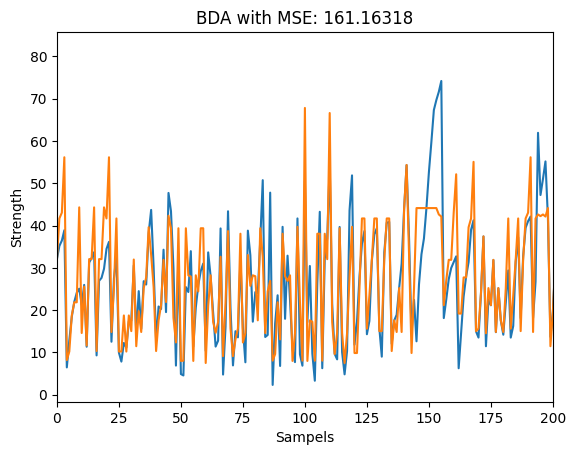

In [158]:
import matplotlib.pyplot as plt
plt.plot(Yt.reset_index(drop=True))
plt.plot(ypre)
plt.xlim(0, 200)
plt.title('BDA with MSE: '+ str(acc))
plt.xlabel('Sampels')
plt.ylabel('Strength')
plt.show()

## Test WBDA

In [156]:
wbda = BDA(kernel_type='primal', dim=30, lamb=1, mode='WBDA', gamma=1, estimate_mu=False)
acc, ypre, list_acc = wbda.fit_predict(Xs, Ys, Xt, Yt)
print(f'The accuracy of WBDA is: {acc:.4f}')

WBDA iteration [1/10]: Acc: 161.1632
WBDA iteration [2/10]: Acc: 161.1632
WBDA iteration [3/10]: Acc: 161.1632
WBDA iteration [4/10]: Acc: 161.1632
WBDA iteration [5/10]: Acc: 161.1632
WBDA iteration [6/10]: Acc: 161.1632
WBDA iteration [7/10]: Acc: 161.1632
WBDA iteration [8/10]: Acc: 161.1632
WBDA iteration [9/10]: Acc: 161.1632
WBDA iteration [10/10]: Acc: 161.1632
The accuracy of WBDA is: 161.1632


In [20]:
from TL_Regression_Methods.TwoStageTrAdaBoostR2 import TwoStageTrAdaBoostR2

regr_1 = TwoStageTrAdaBoostR2(DecisionTreeRegressor(max_depth=8),
                      n_estimators = n_estimators, sample_size = sample_size, 
                      steps = steps, fold = fold, 
                      random_state = random_state)
regr_1.fit(X, y)
y_pred1 = regr_1.predict(x_target_test)

# 4.3 As comparision, use AdaBoostR2 without transfer learning
#==============================================================================
regr_2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=8),
                          n_estimators = n_estimators)
#==============================================================================
regr_2.fit(x_target_train, y_target_train)
y_pred2 = regr_2.predict(x_target_test)

NameError: name 'DecisionTreeRegressor' is not defined

## JDA

In [38]:
from TL_Regression_Methods.JDA import JDA

jda = JDA(kernel_type='primal', dim=30, lamb=1, gamma=1)
acc, ypre, list_acc = jda.fit_predict(Xs, Ys, Xt, Yt)
print(f'The accuracy of JDA is: {acc:.4f}')

ImportError: cannot import name 'JDA' from 'TL_Regression_Methods.JDA' (c:\Users\lemaye\Desktop\GitHub\BA_transfer_learning\TL_Regression_Methods\JDA.py)

In [35]:
from JDA import JDA

jda = JDA(kernel_type='primal', dim=30, lamb=1, gamma=1)
acc, ypre, list_acc = jda.fit_predict(Xs, Ys, Xt, Yt)
print(f'The accuracy of JDA is: {acc:.4f}')

NameError: name 'kernel' is not defined

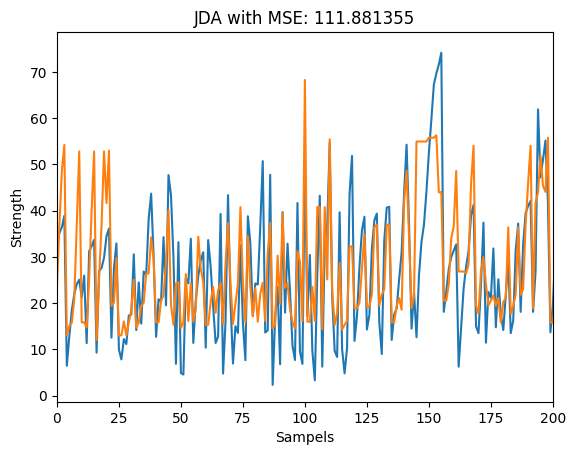

In [161]:
import matplotlib.pyplot as plt
plt.plot(Yt.reset_index(drop=True))
plt.plot(ypre)
plt.xlim(0, 200)
plt.title('JDA with MSE: '+ str(acc))
plt.xlabel('Sampels')
plt.ylabel('Strength')
plt.show()

## Coral

In [115]:
coral = CORAL()
k = 1
acc, ypre = coral.fit_predict(Xs, Ys, Xt, Yt, k)
print(f'The MSE of JDA is: {acc:.4f}')

The MSE of JDA is: 358.4248


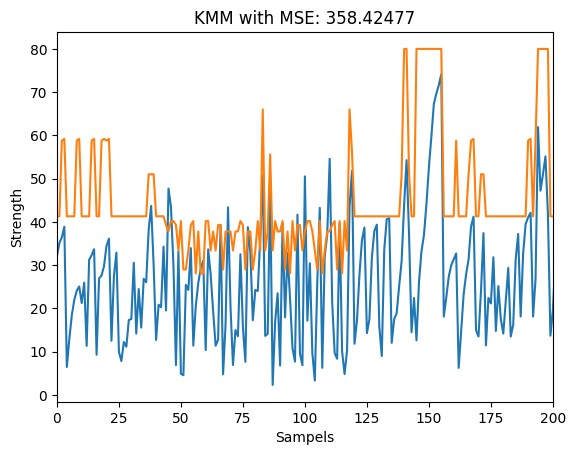

In [116]:
import matplotlib.pyplot as plt
plt.plot(Yt.reset_index(drop=True))
plt.plot(ypre)
plt.xlim(0, 200)
plt.title('KMM with MSE: '+ str(acc))
plt.xlabel('Sampels')
plt.ylabel('Strength')
plt.show()

## GFK

In [28]:
gfk = GFK(dim=20)
acc, ypred, G = gfk.fit_predict(Xs, Ys, Xt, Yt)
print(f'The accuracy of GFK is: {MSE:.4f}')
# Import fehlt

NameError: name 'bob' is not defined

## KMM

In [92]:
model = KNeighborsRegressor(n_neighbors=7)
model.fit(Xs, Ys)
Yt_pred = model.predict(Xt)
acc = sklearn.metrics.mean_squared_error(Yt, Yt_pred)
print(f'MSE using KMM: {acc:.2f}')

MSE using KMM: 97.45


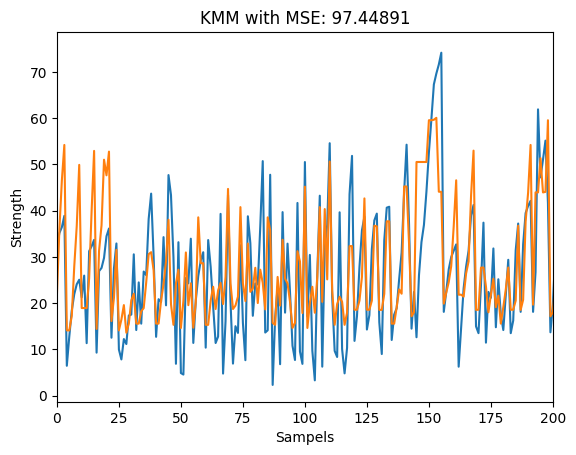

In [93]:
import matplotlib.pyplot as plt
plt.plot(Yt.reset_index(drop=True))
plt.plot(Yt_pred)
plt.xlim(0, 200)
plt.title('KMM with MSE: '+ str(acc))
plt.xlabel('Sampels')
plt.ylabel('Strength')
plt.show()

In [55]:
scl = SCL()
acc, ypred = scl.fit_predict(Xs, Xt, df_src, Ys, df_tar)
print(f'The accuracy of GFK is: {MSE:.4f}')

IndexError: index 7 is out of bounds for axis 1 with size 7

In [57]:
sfa = SFA()
acc, ypred = sfa.fit_predict(Xs, Xt, df_src, Ys, df_tar)
print(f'The accuracy of GFK is: {MSE:.4f}')

TypeError: invalid indexing of 0-dim memory

In [ ]:
meda = MEDA(kernel_type='rbf', dim=20, lamb=10, rho=1.0, eta=0.1, p=10, gamma=1, T=10)
acc, ypre, list_acc = meda.fit_predict(Xs, Ys, Xt, Yt)
print(f'The accuracy of MEDA is: {acc:.4f}')
# Import fehlt

In [17]:
#BDA
bda = BDA(kernel_type='primal', dim=30, lamb=1, mu=0.5, mode='BDA', gamma=1, estimate_mu=False)
mse_bda, ypre_bda, list_acc = bda.fit_predict(Xs, Ys, Xt, Yt)

#JDA
jda = JDA(kernel_type='primal', dim=30, lamb=1, gamma=1)
mse_jda, ypre_jda, list_acc = jda.fit_predict(Xs, Ys, Xt, Yt)

#Coral
coral = CORAL()
k = 1
mse_cor, ypre_cor = coral.fit_predict(Xs, Ys, Xt, Yt, k)

#KMM
model = KNeighborsRegressor(n_neighbors=7)
model.fit(Xs, Ys)
ypre_kmm = model.predict(Xt)
mse_kmm = sklearn.metrics.mean_squared_error(Yt, ypre_kmm)


print(f'The MSE of BDA is: {mse_bda:.4f}')
print(f'The MSE of JDA is: {mse_jda:.4f}')
print(f'The MSE of JDA is: {mse_cor:.4f}')
print(f'The MSE of KMM is: {mse_kmm:.2f}')

BDA iteration [1/10]: Acc: 161.1632
BDA iteration [2/10]: Acc: 161.1632
BDA iteration [3/10]: Acc: 161.1632
BDA iteration [4/10]: Acc: 161.1632
BDA iteration [5/10]: Acc: 161.1632
BDA iteration [6/10]: Acc: 161.1632
BDA iteration [7/10]: Acc: 161.1632
BDA iteration [8/10]: Acc: 161.1632
BDA iteration [9/10]: Acc: 161.1632
BDA iteration [10/10]: Acc: 161.1632
JDA iteration [1/10]: MSE: 111.8814
JDA iteration [2/10]: MSE: 111.8814
JDA iteration [3/10]: MSE: 111.8814
JDA iteration [4/10]: MSE: 111.8814
JDA iteration [5/10]: MSE: 111.8814
JDA iteration [6/10]: MSE: 111.8814
JDA iteration [7/10]: MSE: 111.8814
JDA iteration [8/10]: MSE: 111.8814
JDA iteration [9/10]: MSE: 111.8814
JDA iteration [10/10]: MSE: 111.8814
The MSE of BDA is: 161.1632
The MSE of JDA is: 111.8814
The MSE of JDA is: 358.4248
The MSE of KMM is: 97.45


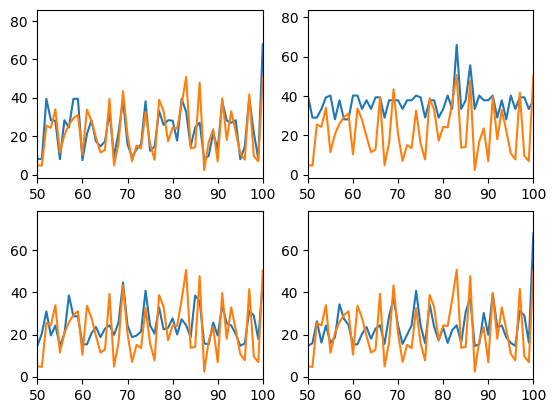

In [37]:
import matplotlib.pyplot as plt
# Create four polar axes and access them through the returned array
fig, ax = plt.subplots(2, 2)
ax[0, 0].plot(ypre_bda)
ax[0, 1].plot(ypre_cor)
ax[1, 0].plot(ypre_kmm)
ax[1, 1].plot(ypre_jda)
ax[0, 0].plot(Yt.reset_index(drop=True))
ax[0, 1].plot(Yt.reset_index(drop=True))
ax[1, 0].plot(Yt.reset_index(drop=True))
ax[1, 1].plot(Yt.reset_index(drop=True))
ax[0, 0].set_xlim([50, 100])
ax[0, 1].set_xlim([50, 100])
ax[1, 0] .set_xlim([50, 100])
ax[1, 1].set_xlim([50, 100])

#ax.set_xlabel('Sampels')
#ax.set_ylabel('Strength')

plt.show()